# Problem Set 6

Franklin She, Selina Ni

## Problem 1

### 1.

#### (a)

$$
\begin{aligned}
\|z\|_2^2 &= \sum_{i=1}^{m_1+m_2} z_i^2 \\
&= \sum_{i=1}^{m_1} z_{1i}^2 + \sum_{i=1}^{m_2} z_{2i}^2 \\
&= \|z_1\|_2^2 + \|z_2\|_2^2
\end{aligned}
$$

#### (b)

$$
\begin{aligned}
f(y, X, \beta, \lambda, \alpha) &= \frac{1}{2n} \| Y - \beta_0 1_{n \times 1} - X \beta \| _2^2 + \lambda \left( \alpha \|\beta\|_1 + (1 - \alpha) \frac{1}{2} \|\beta\|_2^2 \right) \\

&= \frac{1}{2n} \| Y - \beta_0 1_{n \times 1} - X \beta \| _2^2 + \lambda \left( \alpha \|\beta\|_1\right) + \lambda \left((1 - \alpha) \frac{1}{2} \|\beta\|_2^2 \right) \\

&= \frac{1}{2n} \| Y - \beta_0 1_{n \times 1} - X \beta \| _2^2 + \lambda \left((1 - \alpha) \frac{1}{2} \|\beta\|_2^2 \right) + \lambda \left( \alpha \|\beta\|_1\right) \\

&= \frac{1}{2n} \| Y - \beta_0 1_{n \times 1} - X \beta \| _2^2 +  \|\sqrt{(1 - \alpha)\lambda} I_p \beta\|_2^2  + \lambda  \alpha \|\beta\|_1 \\

&= \frac{1}{2n} \| Y - \beta_0 1_{n \times 1} - X \beta +  \sqrt{(1 - \alpha)\lambda} I_p \beta\|_2^2  + \lambda  \alpha \|\beta\|_1 \\

&= \frac{1}{2n} \|\tilde{y} - \tilde{I}\beta_0 - \tilde{X}\beta\|_2^2 + \lambda\alpha\|\beta\|_1
\end{aligned}
$$

#### (c)

By transforming the problem into a form that combines both the LASSO and Ridge penalties into a single quadratic term, it simplifies the optimization process. This approach provides a unified framework to handle both L1 (LASSO) and L2 (Ridge) penalties by adjusting the parameter. When $\alpha =1$, it effectively becomes a LASSO problem, and when $\alpha =0$, it effectively becomes a Ridge problem. The augmented formulation also could make it easier to apply coordinate descent algorithms.

### 2.

#### (a)

This program is a coordinate descent optimization problem. Given a candidate value for the coefficient vector $\beta$, denoted as $\tilde{\beta}$, the program aims to minimize the function $f(y, X, \beta, \alpha)$ by only changing the $j$-th component of $\beta$ and keeping all other components ($l \neq j$) fixed at their current values in $\tilde{\beta}$.

In other words, it's trying to find the best value for the $j$-th coefficient, assuming all other coefficients are fixed, in order to minimize the objective function. This process is repeated for each coefficient in $\beta$, one at a time, until the algorithm converges to an optimal solution.

In [269]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

In [270]:
def load_data(file_path, normalize=False):
    """
    Load the dataset from a CSV file, ignoring the first index column, 
    and separate it into features (X) and the target variable (y).
    """
    # Load the dataset, setting the first column as the index
    df = pd.read_csv(file_path, index_col=0)
    
    y = df['V1'] # "V1" is the target variable
    X = df.drop(columns=['V1'])

    if normalize:
        X = (X - X.mean()) / X.std(ddof=0) 
    
    return X, y


#### (b)

In [271]:
def soft_thresholding(a, b):
    """Soft-thresholding function."""
    return np.sign(a) * np.maximum(np.abs(a) - b, 0)

def calculate_beta_j_star(y, X, lambda_, alpha, beta_tilde, j):
    """Calculates beta_j_star for a given j using soft-thresholding."""
    n = len(y)
    if isinstance(X, pd.DataFrame):
        X = X.values

    if j == 0:  # Intercept case, should not be regularized
        return beta_tilde[0]
    
    x_j = X[:, j-1]  # Adjusted to account for the intercept in beta_tilde

    prediction_excl_j = np.dot(X, beta_tilde[1:]) - x_j * beta_tilde[j]
    residual = y - (prediction_excl_j + beta_tilde[0])
    rho_j = np.dot(x_j, residual) / n
    
    # Apply soft-thresholding to find beta_j_star, considering j > 0
    beta_j_star = soft_thresholding(rho_j, alpha * lambda_)

    return beta_j_star



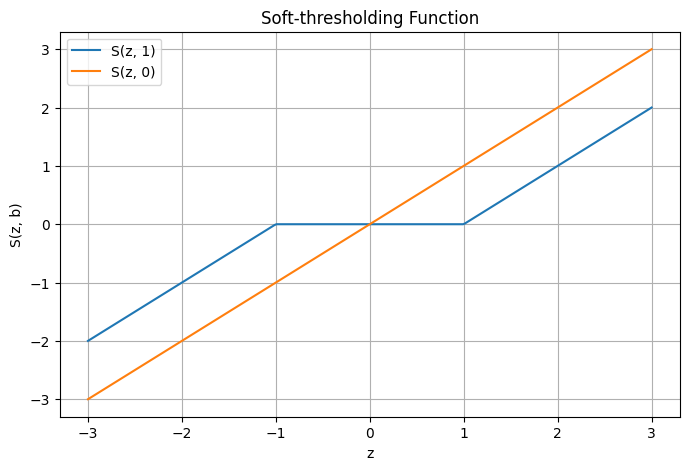

In [272]:
import matplotlib.pyplot as plt

z = np.linspace(-3, 3, 300)
plt.figure(figsize=(8, 5))
plt.plot(z, soft_thresholding(z, 1), label='S(z, 1)')
plt.plot(z, soft_thresholding(z, 0), label='S(z, 0)')
plt.xlabel('z')
plt.ylabel('S(z, b)')
plt.legend()
plt.title('Soft-thresholding Function')
plt.grid(True)
plt.show()


#### (c)

$S(z,1)$ is promotes sparsity by potentially setting a significant proportion of the coefficients to zero when $z$ falls within $[−1,1]$. This characteristic is essential for feature selection and reducing model complexity.

$S(z,0)$ reflects the OLS update mechanism without regularization, where sparsity is not enforced. The likelihood of $S(z,0)$ being zero is minimal unless $z$ is exactly zero, indicating no direct push towards sparsity.

### 3.

In [281]:
def objective_function(y, X, beta, lambda_, alpha):
    """Compute the objective function value for given lambda and alpha."""
    n = len(y)
    prediction = np.dot(X, beta[1:]) + beta[0]
    residual = y - prediction
    beta_norm2_squared = np.sum(beta[1:] ** 2)
    beta_norm1 = np.sum(np.abs(beta[1:]))
    objective = (1 / (2 * n)) * np.sum(residual ** 2) + lambda_ * (alpha * beta_norm1 + (1 - alpha) * 0.5 * beta_norm2_squared)
    return objective


In [282]:
def cyclic_coordinate_descent_wo_active_set(y, X, lambda_, alpha, epsilon=0.1, max_iter=100, beta_init=None, verbose=False):
    n, p = X.shape
    # Use beta_init if provided, otherwise initialize as before
    beta = beta_init if beta_init is not None else np.zeros(p + 1)
    iter_count = 0
    
    obj_prev = objective_function(y, X, beta, lambda_, alpha)

    while iter_count < max_iter:
        for j in range(p + 1):
            if j == 0:  # Update intercept without regularization
                beta[j] = beta[j] + np.mean(y - np.dot(X, beta[1:]) - beta[0])
            else:
                # Update other coefficients with regularization
                beta[j] = calculate_beta_j_star(y, X, lambda_, alpha, beta, j)
        
        # Calculate new objective function value after all beta updates
        obj_curr = objective_function(y, X, beta, lambda_, alpha)
        
        # Calculate change in the objective function
        obj_change = np.abs(obj_curr - obj_prev)

        if verbose:
            print(f"Iteration {iter_count}, Objective Function: {obj_curr}")
        
        if obj_change < epsilon:  # Convergence check based on objective function change
            break

        obj_prev = obj_curr  # Update previous objective function value
        iter_count += 1

    return beta


### 4.

In [283]:
def cyclic_coordinate_descent_w_active_set(y, X, lambda_, alpha, epsilon=0.1, max_iter=100, beta_init=None, verbose=False):
    n, p = X.shape
    # Use beta_init if provided, otherwise initialize as before
    beta = beta_init if beta_init is not None else np.zeros(p + 1)
    active_set = list(range(p + 1))  # Initially, all indices are in the active set
    iter_count = 0
    obj_prev = objective_function(y, X, beta, lambda_, alpha)

    while iter_count < max_iter:
        for j in active_set:
            if j == 0:  # Update intercept without regularization
                beta[j] = beta[j] + np.mean(y - np.dot(X, beta[1:]) - beta[0])
            else:
                # Update other coefficients with regularization
                beta[j] = calculate_beta_j_star(y, X, lambda_, alpha, beta, j)
        
        # After cycling through the active set, check for convergence
        obj_curr = objective_function(y, X, beta, lambda_, alpha)
        obj_change = np.abs(obj_curr - obj_prev)

        if verbose:
            print(f"Iteration {iter_count}, Objective Function: {obj_curr}")

        if obj_change < epsilon:  # Check convergence on active set
            if len(active_set) < p + 1:
                active_set = list(range(p + 1))  # Reconsider all coefficients
                continue 
            else:
                break
        else:
            # Update active set based on current non-zero parameters
            active_set = [0] + [j for j in range(1, p + 1) if beta[j] != 0]

        obj_prev = obj_curr
        iter_count += 1

    return beta


### 5.

In [284]:
import numpy as np

def compute_lambda_sequence(y, X, l=10, delta=0.01):
    """
    Compute the lambda sequence for LASSO/Ridge/Elastic-net regularization.
    """
    n, p = X.shape
    lambda_max = np.max(np.abs(X.T @ y)) / np.sqrt(n)
    lambda_min = delta * lambda_max
    
    # Create an equidistant sequence in log-space
    log_lambda_sequence = np.linspace(np.log(lambda_min), np.log(lambda_max), l)
    
    # Return the exponential of the sequence to get the lambda sequence in linear scale
    return np.exp(log_lambda_sequence)[::-1] # Reverse to start from lambda_max to lambda_min


### 6.

In [286]:
def cyclic_coordinate_descent_with_warm_starts(y, X, lambdas, alpha, epsilon=0.1, max_iter=100, use_active_set=False, verbose=False):
    n, p = X.shape
    beta_init = np.zeros(p + 1)  # Initialize beta for the highest lambda value
    betas = {}
    
    if use_active_set:
        coordinate_descent_method = cyclic_coordinate_descent_w_active_set
    else:
        coordinate_descent_method = cyclic_coordinate_descent_wo_active_set
    
    for lambda_val in lambdas:
        if verbose:
            print("lambda: ", lambda_val)
        
        # Assuming the coordinate descent method accepts beta_init
        beta = coordinate_descent_method(y, X, lambda_val, alpha, epsilon, max_iter, beta_init=beta_init, verbose=verbose)
        
        betas[lambda_val] = beta
        beta_init = beta.copy()  # Prepare for the next lambda: warm-start
        
    return betas

def cyclic_coordinate_descent_without_warm_starts(y, X, lambdas, alpha, epsilon=0.1, max_iter=100, use_active_set=False, verbose=False):
    n, p = X.shape
    betas = {}
    
    if use_active_set:
        coordinate_descent_method = cyclic_coordinate_descent_w_active_set
    else:
        coordinate_descent_method = cyclic_coordinate_descent_wo_active_set
    
    for lambda_val in lambdas:
        if verbose:
            print("lambda: ", lambda_val)
        
        # Initialize beta coefficients from scratch for each lambda
        beta_init = np.zeros(p + 1)
        
        beta = coordinate_descent_method(y, X, lambda_val, alpha, epsilon, max_iter, beta_init=beta_init, verbose=verbose)
        
        betas[lambda_val] = beta
        
    return betas


### 7.

In [298]:
def run_5_fold_cv_4_configs(X, y, lambdas, alpha, verbose=False):
    print("Running 5-fold cross-validation for 4 configurations with alpha =", alpha)
    # 5-fold cross-validation
    kf = KFold(n_splits=5)

    # Initialize dictionaries to hold running times and parameter estimates for each configuration
    running_times = {}
    parameter_estimates_all_configs = {}

    configs = [
        ('active_warm', True, True),
        ('active_not_warm', True, False),
        ('not_active_warm', False, True),
        ('not_active_not_warm', False, False)
    ]

    # Loop through configurations
    for config_name, use_active_set, use_warm_starts in configs:
        start_time = time.time()
        parameter_estimates = np.zeros((len(lambdas), X.shape[1])) 

        fold_count = 0
        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            print(f"Training with {config_name} on fold {fold_count + 1}...")
            fold_count += 1

            if use_warm_starts:
                betas = cyclic_coordinate_descent_with_warm_starts(y_train, X_train, lambdas, alpha=alpha, use_active_set=use_active_set, verbose=verbose)
            else:
                betas = cyclic_coordinate_descent_without_warm_starts(y_train, X_train, lambdas, alpha=alpha, use_active_set=use_active_set, verbose=verbose)
            
            # Aggregate parameter estimates
            for i, lambda_val in enumerate(lambdas):
                parameter_estimates[i] += betas[lambda_val][1:] / 5  # Averaging over folds

        end_time = time.time()

        # Store the running time
        running_times[config_name] = end_time - start_time
        
        # Store parameter estimates for the current configuration
        parameter_estimates_all_configs[config_name] = parameter_estimates

    return running_times, parameter_estimates_all_configs

def plot_parameter_estimates_print_times(parameter_estimates_all_configs, lambdas, running_times):
    # Plotting
    plt.figure(figsize=(15, 10))
    for i, (config_name, parameter_estimates) in enumerate(parameter_estimates_all_configs.items()):
        for j in range(parameter_estimates.shape[1]):
            plt.subplot(2, 2, i + 1)
            plt.plot(lambdas, parameter_estimates[:, j], label="Parameter estimates")
            plt.gca().set_xscale('log')
            plt.title(f'Config: {config_name.replace("_", " ").title()}')
            plt.xlabel('lambda')
            plt.ylabel('Coefficient Value')
            if j == 0:
                plt.legend()

    plt.tight_layout()
    plt.show()

    # Printing running times
    for config_name, time_elapsed in running_times.items():
        print(f"Running time with {config_name}: {time_elapsed:.2f} seconds")

In [ ]:
X, y = load_data('ps6.csv', normalize=True)
lambdas = compute_lambda_sequence(y, X)

running_times_lasso, parameter_estimates_all_configs_lasso = run_5_fold_cv_4_configs(X, y, lambdas, alpha=1)

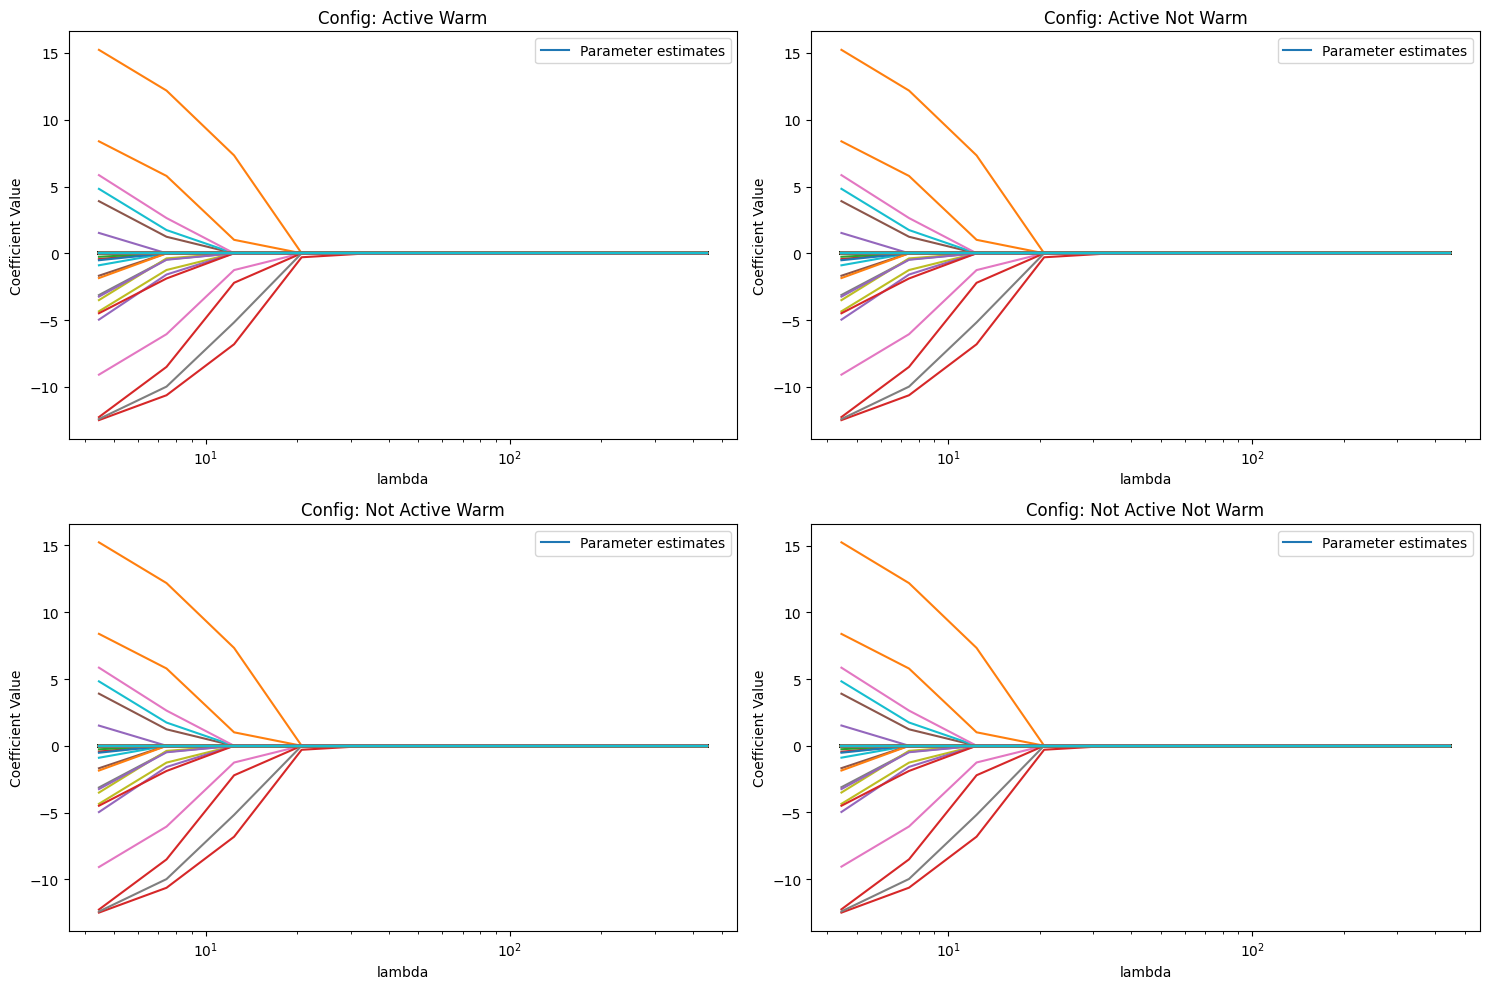

Running time with active_warm: 30.67 seconds
Running time with active_not_warm: 41.55 seconds
Running time with not_active_warm: 32.90 seconds
Running time with not_active_not_warm: 47.62 seconds


In [299]:
plot_parameter_estimates_print_times(parameter_estimates_all_configs_lasso, lambdas, running_times_lasso)

### 8.

In [ ]:
X, y = load_data('ps6.csv', normalize=True)
lambdas = compute_lambda_sequence(y, X)
running_times_ridge, parameter_estimates_all_configs_ridge = run_5_fold_cv_4_configs(X, y, lambdas, alpha=0)

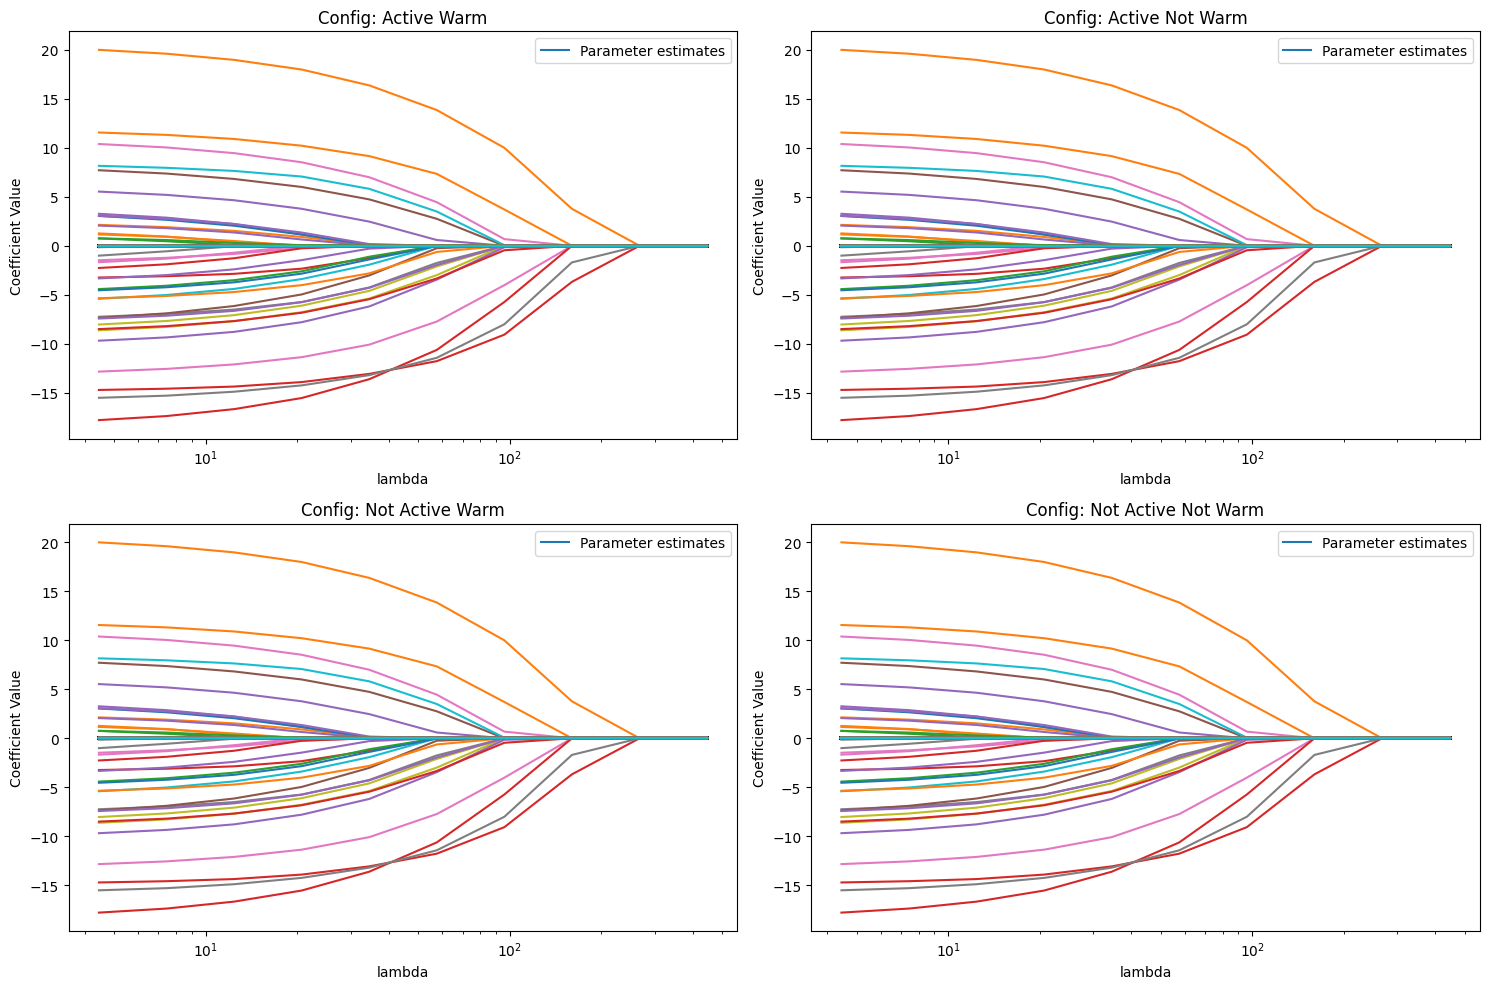

Running time with active_warm: 51.02 seconds
Running time with active_not_warm: 66.97 seconds
Running time with not_active_warm: 172.60 seconds
Running time with not_active_not_warm: 182.84 seconds


In [300]:
plot_parameter_estimates_print_times(parameter_estimates_all_configs_ridge, lambdas, running_times_ridge)

### 9.

In [301]:
elastic_net = {}
alphas = [round(i * 0.1, 1) for i in range(1, 11)]

X, y = load_data('ps6.csv', normalize=True)
lambdas = compute_lambda_sequence(y, X)

for alpha in alphas:
    running_times, parameter_estimates_all_configs = run_5_fold_cv_4_configs(X, y, lambdas, alpha)
    elastic_net[alpha] = (running_times, parameter_estimates_all_configs)


Running 5-fold cross-validation for 4 configurations with alpha = 0.1
Training with active_warm on fold 1...
Training with active_warm on fold 2...
Training with active_warm on fold 3...
Training with active_warm on fold 4...
Training with active_warm on fold 5...
Training with active_not_warm on fold 1...
Training with active_not_warm on fold 2...
Training with active_not_warm on fold 3...
Training with active_not_warm on fold 4...
Training with active_not_warm on fold 5...
Training with not_active_warm on fold 1...
Training with not_active_warm on fold 2...
Training with not_active_warm on fold 3...
Training with not_active_warm on fold 4...
Training with not_active_warm on fold 5...
Training with not_active_not_warm on fold 1...
Training with not_active_not_warm on fold 2...
Training with not_active_not_warm on fold 3...
Training with not_active_not_warm on fold 4...
Training with not_active_not_warm on fold 5...
Running 5-fold cross-validation for 4 configurations with alpha = 0.2


In [302]:
for alpha, (running_times, _) in elastic_net.items():
    print(f"Running times for alpha = {alpha}")
    for config_name, time_elapsed in running_times.items():
        print(f"Running time with {config_name}: {time_elapsed:.2f} seconds")
    print("----------------------------------------------------")

Running times for alpha = 0.1
Running time with active_warm: 41.47 seconds
Running time with active_not_warm: 40.46 seconds
Running time with not_active_warm: 56.84 seconds
Running time with not_active_not_warm: 97.79 seconds
----------------------------------------------------
Running times for alpha = 0.2
Running time with active_warm: 35.47 seconds
Running time with active_not_warm: 32.68 seconds
Running time with not_active_warm: 71.31 seconds
Running time with not_active_not_warm: 543.65 seconds
----------------------------------------------------
Running times for alpha = 0.3
Running time with active_warm: 24.22 seconds
Running time with active_not_warm: 28.13 seconds
Running time with not_active_warm: 39.71 seconds
Running time with not_active_not_warm: 52.18 seconds
----------------------------------------------------
Running times for alpha = 0.4
Running time with active_warm: 20.70 seconds
Running time with active_not_warm: 30.47 seconds
Running time with not_active_warm: 46.

### 10.

Lasso regression leads to sparse estimates by shrinking some coefficients to zero, effectively performing feature selection. This sparsity increases with larger values of $\lambda$, making it distinctive for its ability to produce models that only include the most influential variables. In contrast, Ridge regression does not inherently produce sparse models as it shrinks coefficients toward zero but typically does not set them exactly to zero, while Elastic Net, which combines penalties from both Lasso and Ridge, can also lead to sparse estimates depending on the mixing parameter $\alpha$.

## Problem 2

##

